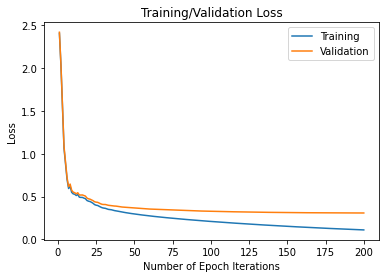

Final training loss = 0.11080421900310469
Final validation loss = 0.3086722443085267


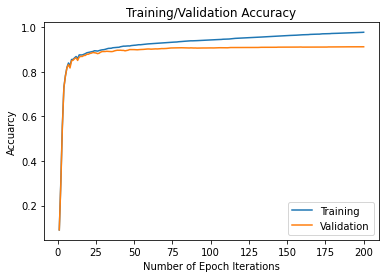

Final training accuracy = 0.9774
FInal validation accuracy = 0.9121666666666667


In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import math
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# Load the data
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget


# Implementation of a neural network using only Numpy - trained using gradient descent with momentum
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))

    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest


def shuffle(trainData, trainTarget):
    np.random.seed(421)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target


def relu(x):
    # ReLU(x) = max(x,0) 
    return np.maximum(x,0)


def softmax(x):
    # subtract the maximum value of x to prevent overflow while computing exponentials
    max_x = np.max(x, axis=1, keepdims=True) #largest number on each row（axis=1）
    exp_x = np.exp(x - max_x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True) 


def computeLayer(X, W, b):
    # product between the weights and input, plus the biases as the prediction of a given layer
    return np.matmul(X, W) + b


def CE(target, prediction):
    # number of examples N
    N = len(target)
    return (-1/N) * np.sum(target * np.log(prediction))


def gradCE(target, prediction):
    # delta L / delta oi = pi - yi 
    N = len(target)
    return (softmax(prediction) - target)/N


if __name__ == '__main__':

    # load data from file
    trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

    # Calculate the dimension of each figure 28*28 = 784
    F = int(trainData.size / trainData.shape[0])

    # Reshape the Data set to N * F matrix
    trainData = np.reshape(trainData, (-1, F)) 
    validData = np.reshape(validData, (-1, F))
    testData = np.reshape(testData, (-1, F))

    # convert the data into one-hot encoding format
    newtrain, newvalid, newtest = convertOneHot(trainTarget, validTarget, testTarget) 
    K = newtrain.shape[1]

    # parameter declaration
    num_epoches = 200
    H = 1000 # hidden unit size
    
    mean = 0
    varience_h = 2 / (F + H) # 2/(units in + units out)
    stan_de_h = math.sqrt(varience_h)
    varience_o = 2 / (H + K) # 2/(units in + units out)
    stan_de_o = math.sqrt(varience_o)

    w_h = np.random.normal(mean, stan_de_h, (F, H)) # output shape as (FxH), hidden layer weights
    b_h = np.zeros((1,H)) # hidden layer biases (1xH)
    w_o = np.random.normal(mean, stan_de_o, (H, K)) # output layer weights (HxK)
    b_o = np.zeros((1, K)) # output layer biases (1xK)

    small_value = 1e-5
    v_wh = np.full(w_h.shape, small_value) # the same size as the hidden layer weight matrix sizes 
    v_wo = np.full(w_o.shape, small_value) # the same size as the output layer weight matrix sizes 

    alpha = 0.1
    gamma = 0.9

    train_loss, train_acc, val_loss, val_acc = [], [], [], []

    for i in range(num_epoches):

        # shuffle data
        trainData, newtrain = shuffle(trainData, newtrain)
      
        # 1. compute forward propogation: 
        s_0 = computeLayer(trainData, w_h, b_h)   # x_0 = trainData
        x_1 = relu(s_0)
        s_1 = computeLayer(x_1, w_o, b_o)
        x_2 = softmax(s_1)

        val_s_0 = computeLayer(validData, w_h, b_h)   # x_0 = validData
        val_x_1 = relu(val_s_0)
        val_s_1 = computeLayer(val_x_1, w_o, b_o)
        val_x_2 = softmax(val_s_1)

        # 2. compute back propogation: 

        # 2.0.1 gradient of loss of the output layer
        dl_ds1 = gradCE(newtrain, s_1) # s_1 = o (input of the softmax function)

        # 2.1 gradient of loss respect to the output layer weights
        dl_dwo = np.matmul(x_1.T, dl_ds1)

        # 2.2 gradient of loss respect to the output layer biases
        dl_dbo = np.sum(dl_ds1, axis=0, keepdims=True) # sum up along axis=0(each column NxK -> 1xK)

        # 2.0.2 The gradient of the loss with respect to the input to the ReLu() function
        dl_dx1 = np.matmul(dl_ds1, w_o.T) 
        dl_ds0 = np.where(x_1>0, 1, 0) * dl_dx1 

        # 2.3 gradient of loss respect to the hidden layer weights
        dl_dwh = np.matmul(trainData.T, dl_ds0) #  x_0 = trainData

        # 2.4 gradient of loss respect to the hidden layer biases
        dl_dbh = np.sum(dl_ds0, axis=0, keepdims=True) # sum up along axis=0(each column NxH -> 1xH)

        # 3.  updating all of the network's weights and biases
        v_wh = gamma * v_wh + alpha * dl_dwh
        v_wo = gamma * v_wo + alpha * dl_dwo
        w_h = w_h - v_wh
        w_o = w_o - v_wo
        b_h = b_h - alpha * dl_dbh
        b_o = b_o - alpha * dl_dbo

        # compute loss and accuracy
        train_loss.append(CE(newtrain, x_2))
        val_loss.append(CE(newvalid, val_x_2))
        train_acc.append(np.mean(np.argmax(x_2, axis=1) == np.argmax(newtrain, axis=1)))
        val_acc.append(np.mean(np.argmax(val_x_2, axis=1) == np.argmax(newvalid, axis=1)))

    # print and plot the loss & accuracy graphs
    x = range(1, num_epoches+1)

    plt.plot(x, train_loss, label='Training')
    plt.plot(x, val_loss, label='Validation')
    plt.xlabel("Number of Epoch Iterations")
    plt.ylabel("Loss")
    plt.legend(loc = 'best')
    plt.title("Training/Validation Loss")
    plt.show()

    print('Final training loss = ' + str(train_loss[-1]))
    print('Final validation loss = ' + str(val_loss[-1]))

    plt.plot(x, train_acc, label = 'Training')
    plt.plot(x, val_acc, label = 'Validation')
    plt.xlabel("Number of Epoch Iterations")
    plt.ylabel("Accuarcy")
    plt.legend(loc = 'best')
    plt.title("Training/Validation Accuracy")
    plt.show()

    print('Final training accuracy = ' + str(train_acc[-1]))
    print('FInal validation accuracy = ' + str(val_acc[-1]))